In [1]:
import numpy as np
import networkx as nx
# import rustworkx as nx
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from itertools import islice
# %matplotlib qt
import shapely
import matplotlib.patheffects as pe
import contextily as cx

In [2]:
smoothing=1/4
runnr=2
stadnamen=['Leeuwarden', 'Drachten', 'Sneek', 'Heerenveen', 'Harlingen','Joure', 'Wolvega', 'Franeker', 'Dokkum', 'Lemmer', 'Bolsward','Burgum']
spawn_hoeveelheden={160: 20.0, 199: 20.0, 'Leeuwarden': 66.0, 'Drachten': 36.0, 'Sneek': 27.0, 'Harlingen': 12.0, 'Joure': 10.0, 'Wolvega': 11.0, 'Franeker': 10.0, 'Dokkum': 10.0, 'Lemmer': 10.0, 'Bolsward': 10.0, 'Burgum': 10.0, 'Heerenveen': 24.0}

nodes_gpd = gpd.read_file('./wegengraaf2lwk/points.shp')
lines_gpd = gpd.read_file('./wegengraaf2lwk/lines.shp')
change_to_2=[(201,202),(202,35),(35,225),(225,105),"N356","031",(123,256),(256,219),(219,160)]
def update_lanes_to2(row):
    if (row["node_end"],row["node_start"]) in change_to_2 or (row["node_start"],row["node_end"]) in change_to_2 or row["wegnr"] in change_to_2:
        row["nbanen"]=2
    return row
lines_gpd=lines_gpd.apply(update_lanes_to2,axis=1)
lines_gpd["capacity"]=lines_gpd['length']*lines_gpd['nbanen']*1/(4.5+lines_gpd['maxshd']/1.8)
nodes_gpd["is_auto_br"][np.isnan(nodes_gpd["is_auto_br"])]=0
nodes_gpd["spawn_hoev"][np.isnan(nodes_gpd["spawn_hoev"])]=0

nodes_gpd["spawn_hoev"][nodes_gpd["nodeID"]==160],nodes_gpd["is_auto_br"][nodes_gpd["nodeID"]==160]=      spawn_hoeveelheden[160],1
nodes_gpd["spawn_hoev"][nodes_gpd["nodeID"]==199],nodes_gpd["is_auto_br"][nodes_gpd["nodeID"]==199]=      spawn_hoeveelheden[199],1 #afsluitdijk
for name in stadnamen:
    nodes_gpd["spawn_hoev"][nodes_gpd["stad_naam"]==name]=spawn_hoeveelheden[name]

C:\Users\Alexander\AppData\Local\Temp\ipykernel_15824\1133753903.py:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  nodes_gpd["is_auto_br"][np.isnan(nodes_gpd["is_auto_br"])]=0
C:\Users\Alexander\AppData\Local\Temp\ipykernel_15824\11337539

In [3]:
def create_graph(nodes_gpd, lines_gpd):
    gf = nx.Graph()
    for _, k in nodes_gpd.iterrows():
        gf.add_node(int(k['nodeID']),
                    x=k['geometry'].x,
                    y=k['geometry'].y,
                    stad_naam=k['stad_naam'],
                    is_auto_br=k['is_auto_br'],
                    spawn_hoev=k['spawn_hoev'])
    for _, row in lines_gpd.iterrows():
        gf.add_edge(int(row['node_start']), int(row['node_end']),
                    wegnr=row['wegnr'],
                    length=row['length'],
                    maxshd=row['maxshd'],
                    nbanen=row['nbanen'])
    return gf

gfd = nx.DiGraph(create_graph(nodes_gpd, lines_gpd))

def weight_edge_min(f, t, attr):
    return attr['length']/attr['maxshd']/1000*60

def weight_edge_dist(f, t, attr):
    return attr['length']

def weight_capacity(f, t, attr):
    cars = np.sum(attr['object'].cars[:, 0])
    capacity = attr['object'].C()
    return attr['length']/attr['maxshd']/1000*60 * (1 + cars/capacity)

def to_directed(gfd, lines_gpd):
    gfd_dir = nx.DiGraph()
    # for n in gfd.nodes():
    #     gfd_dir.add_node(n, x=gfd.nodes[n]['x'], y=gfd.nodes[n]['y'])
    for _, k in nodes_gpd.iterrows():
        gfd_dir.add_node(int(k['nodeID']),
                    x=k['geometry'].x,
                    y=k['geometry'].y,
                    stad_naam=k['stad_naam'],
                    is_auto_br=k['is_auto_br'],
                    spawn_hoev=k['spawn_hoev'])

    for _, row in lines_gpd.iterrows():
        gfd_dir.add_edge(int(row['node_start']), int(row['node_end']),
                    wegnr=row['wegnr'],
                    length=row['length'],
                    maxshd=row['maxshd'],
                    nbanen=row['nbanen'])
    
    return gfd_dir

In [4]:
# def make_homogeneous(lines_gpd):
#     changed = 0
#     # paths = nx.single_source_shortest_path(gfd, 1000)
#     for n in gfd.nodes:
#         path_node = nx.shortest_path(gfd, 1000, n, weight=weight_edge_min)
#         if len(path_node) > 2:
#             previous_node = path_node[-2]
#             # if exists path from prev to current node
#             df_query = lines_gpd[(lines_gpd['node_start'] == previous_node) & (lines_gpd['node_end'] == n)]
#             if len(df_query) == 0:
#                 changed += 1
#                 def update_row(row):
#                     if row['node_end'] == previous_node and row['node_start'] == n:
#                         row['node_start'] = previous_node
#                         row['node_end'] = n
#                     return row
#                 # switch
#                 lines_gpd = lines_gpd.apply(update_row, axis=1)
#     print(f"{changed=}")
#     return lines_gpd

lines_gpd_org = lines_gpd.copy()

# Make all paths with degree 2's in the same direction
def make_homogeneous2(lines_gpd):
    degree_highs = [n for n in gfd.nodes if gfd.out_degree(n) > 2]
    for n in degree_highs:
        def custom_weight(f, t, attr):
            if (f != n and t != n) and (gfd.out_degree(f) > 2 or gfd.out_degree(t) > 2):
                return 900_000
            return weight_edge_min(f, t, attr)
        paths = nx.all_pairs_dijkstra(gfd, cutoff=999_999, weight=custom_weight)
        paths = dict(paths)
        weights, paths = paths[n]
        end_points = [k for k, v in weights.items() if gfd.out_degree(k) != 2 and k != n]
        for end_point in end_points:
            path = paths[end_point]
            for i in range(0, len(path) - 1):
                current = path[i]
                next = path[i+1]
                def update_row(row):
                        if row['node_end'] == current and row['node_start'] == next:
                            # changed += 1
                            row['node_start'] = current
                            row['node_end'] = next
                            print(f"changed ({current}, {next}) -> ({next}, {current})")
                            # row['geometry'] = row['geometry'].reverse()
                        return row
                
                lines_gpd = lines_gpd.apply(update_row, axis=1)
    return lines_gpd


lines_gpd = make_homogeneous2(lines_gpd)
gfd = nx.DiGraph(create_graph(nodes_gpd, lines_gpd))

changed (6, 1000) -> (1000, 6)
changed (175, 174) -> (174, 175)
changed (12, 2) -> (2, 12)
changed (208, 207) -> (207, 208)
changed (208, 207) -> (207, 208)
changed (207, 180) -> (180, 207)
changed (238, 177) -> (177, 238)
changed (178, 160) -> (160, 178)
changed (137, 134) -> (134, 137)
changed (137, 1007) -> (1007, 137)
changed (129, 128) -> (128, 129)
changed (128, 47) -> (47, 128)
changed (65, 64) -> (64, 65)
changed (23, 22) -> (22, 23)
changed (22, 21) -> (21, 22)
changed (34, 31) -> (31, 34)
changed (200, 19) -> (19, 200)
changed (243, 43) -> (43, 243)
changed (243, 43) -> (43, 243)
changed (43, 42) -> (42, 43)
changed (42, 41) -> (41, 42)
changed (130, 103) -> (103, 130)
changed (31, 30) -> (30, 31)
changed (30, 29) -> (29, 30)
changed (44, 1008) -> (1008, 44)
changed (31, 34) -> (34, 31)
changed (34, 21) -> (21, 34)
changed (21, 22) -> (22, 21)
changed (22, 23) -> (23, 22)
changed (32, 31) -> (31, 32)
changed (131, 103) -> (103, 131)
changed (225, 155) -> (155, 225)
changed (2

In [5]:
# def change_geometry(row):
changed_geometries = list()

for i, k in (lines_gpd != lines_gpd_org).node_start.items():
    if k == True:
        print(i, k)
        changed_geometries.append(i)

0 True
2 True
4 True
6 True
7 True
11 True
12 True
14 True
16 True
17 True
18 True
19 True
20 True
21 True
22 True
24 True
26 True
28 True
31 True
32 True
34 True
35 True
38 True
41 True
42 True
44 True
46 True
47 True
48 True
50 True
52 True
55 True
60 True
62 True
64 True
65 True
67 True
68 True
70 True
71 True
72 True
74 True
76 True
77 True
78 True
80 True
83 True
85 True
86 True
88 True
90 True
91 True
93 True
95 True
96 True
98 True
99 True
100 True
101 True
103 True
104 True
106 True
108 True
110 True
113 True
114 True
115 True
116 True
117 True
118 True
119 True
121 True
123 True
124 True
125 True
126 True
127 True
130 True
131 True
132 True
134 True
135 True
136 True
140 True
145 True
146 True
147 True
148 True
149 True
150 True
151 True
152 True
153 True
156 True
157 True
160 True
161 True
163 True
164 True
165 True
166 True
167 True
168 True
171 True
175 True
176 True
177 True
179 True
180 True
181 True
182 True
183 True
184 True
185 True
186 True
187 True
189 True
190 True


In [6]:
tol_dist = 300 # meters

def transform_geometries(row):
    from_l = row['node_start']
    to_l = row['node_end']

    from_p = nodes_gpd[nodes_gpd['nodeID'] == from_l]
    to_p = nodes_gpd[nodes_gpd['nodeID'] == to_l]

    # change points to shapely points
    from_l = shapely.Point(row['geometry'].coords[0])
    to_l = shapely.Point(row['geometry'].coords[-1])

    from_p = from_p.geometry.to_list()[0]
    to_p = to_p.geometry.to_list()[0]

    from_nearby = to_l.distance(to_p) < tol_dist
    to_nearby = from_l.distance(from_p) < tol_dist

    if from_nearby and to_nearby:
        return row
    elif not from_nearby and not to_nearby:
        # print(f'change {from_p} and {to_p}')
        row['geometry'] = row['geometry'].reverse()
        return row
    else:
        print(f'({row.name}) undefined behaviour {from_p} and {to_p}')

lines_gpd_new = lines_gpd.apply(transform_geometries, axis=1)
lines_gpd = lines_gpd_new

<Axes: >

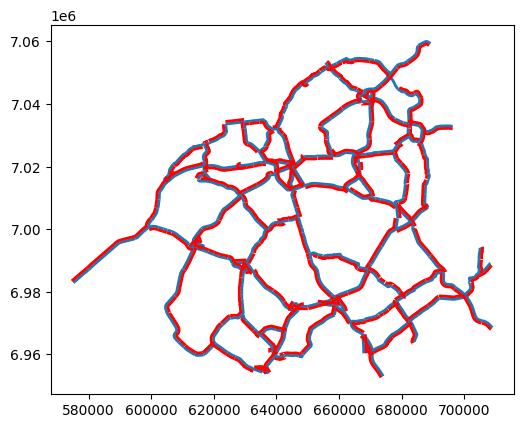

In [7]:
ax = lines_gpd_new.plot(linewidth=2)
lines_gpd_new.offset_curve(-800).plot(ax=ax, linewidth=2, color='red')

In [8]:
# simplify road network by removing unnecessary node 2's

lgpd = lines_gpd.copy()
removed_nodes = list()

for _ in range(999999):
    simplify_roads = list()
    # get suitable roads to simplify
    gfd_dir = to_directed(gfd, lgpd)
    node2 = [u for u in [j for j in gfd_dir.nodes if gfd_dir.out_degree(j) == 1] if gfd_dir.in_degree(u) == 1]
    for r in removed_nodes:
        if r in node2:
            print('removed', r)
            node2.remove(r)
    
    for n in node2:
        edge1 = list(gfd_dir.in_edges(n))[0]
        edge2 = list(gfd_dir.out_edges(n))[0]
        propequal = ['wegnr', 'maxshd', 'nbanen']
        if np.all([gfd_dir.edges[edge1][prop] == gfd_dir.edges[edge2][prop] for prop in propequal]):
            simplify_roads.append((edge1, edge2))

    if len(simplify_roads) == 0:
        break

    f = simplify_roads[0][0]
    t = simplify_roads[0][1]
    from_row = lgpd[(lgpd['node_start'] == f[0]) & (lgpd['node_end'] == f[1])]
    to_row = lgpd[(lgpd['node_start'] == t[0]) & (lgpd['node_end'] == t[1])]
    
    geo1 = from_row.geometry.to_list()[0]
    geo2 = to_row.geometry.to_list()[0]
    dataf = gfd_dir.edges[(f[0], f[1])]
    datat = gfd_dir.edges[(f[0], f[1])]
    removed_nodes.append(f[1])
    df2 = gpd.GeoDataFrame(data={
        'wegnr': [dataf['wegnr']], 
        'length': [dataf['length'] + datat['length']],
        'maxshd': [dataf['maxshd']],
        'node_start': [f[0]],
        'node_end': [t[1]],
        'nbanen': [dataf['nbanen']]},
        geometry=[shapely.ops.linemerge(shapely.geometry.MultiLineString([geo1, geo2]))],
        crs=lgpd.crs)
    print(f"{f[0]} -> {f[1]} => {t[0]} -> {t[1]}")
    lgpd = lgpd.drop([from_row.index[0], to_row.index[0]], axis=0)
    # print(from_row.index[0], to_row.index[0])
    lgpd = pd.concat([lgpd, df2], ignore_index=True)
   

501 -> 1 => 1 -> 0
218 -> 4 => 4 -> 3
251 -> 17 => 17 -> 18
28 -> 27 => 27 -> 112
44 -> 29 => 29 -> 30
44 -> 30 => 30 -> 31
158 -> 37 => 37 -> 38
41 -> 42 => 42 -> 43
128 -> 47 => 47 -> 120
55 -> 53 => 53 -> 54
186 -> 55 => 55 -> 54
232 -> 58 => 58 -> 56
60 -> 61 => 61 -> 161
176 -> 62 => 62 -> 59
64 -> 65 => 65 -> 23
68 -> 67 => 67 -> 66
182 -> 69 => 69 -> 70
182 -> 70 => 70 -> 71
74 -> 73 => 73 -> 72
173 -> 74 => 74 -> 72
114 -> 79 => 79 -> 10
80 -> 81 => 81 -> 83
88 -> 84 => 84 -> 85
92 -> 89 => 89 -> 90
92 -> 90 => 90 -> 91
66 -> 94 => 94 -> 93
97 -> 96 => 96 -> 98
100 -> 101 => 101 -> 102
139 -> 107 => 107 -> 88
111 -> 110 => 110 -> 109
183 -> 111 => 111 -> 109
28 -> 112 => 112 -> 99
115 -> 116 => 116 -> 203
125 -> 117 => 117 -> 57
75 -> 121 => 121 -> 45
126 -> 125 => 125 -> 57
127 -> 126 => 126 -> 57
209 -> 127 => 127 -> 57
129 -> 128 => 128 -> 120
23 -> 129 => 129 -> 120
103 -> 130 => 130 -> 31
216 -> 141 => 141 -> 92
143 -> 142 => 142 -> 172
144 -> 143 => 143 -> 172
146 -> 145 

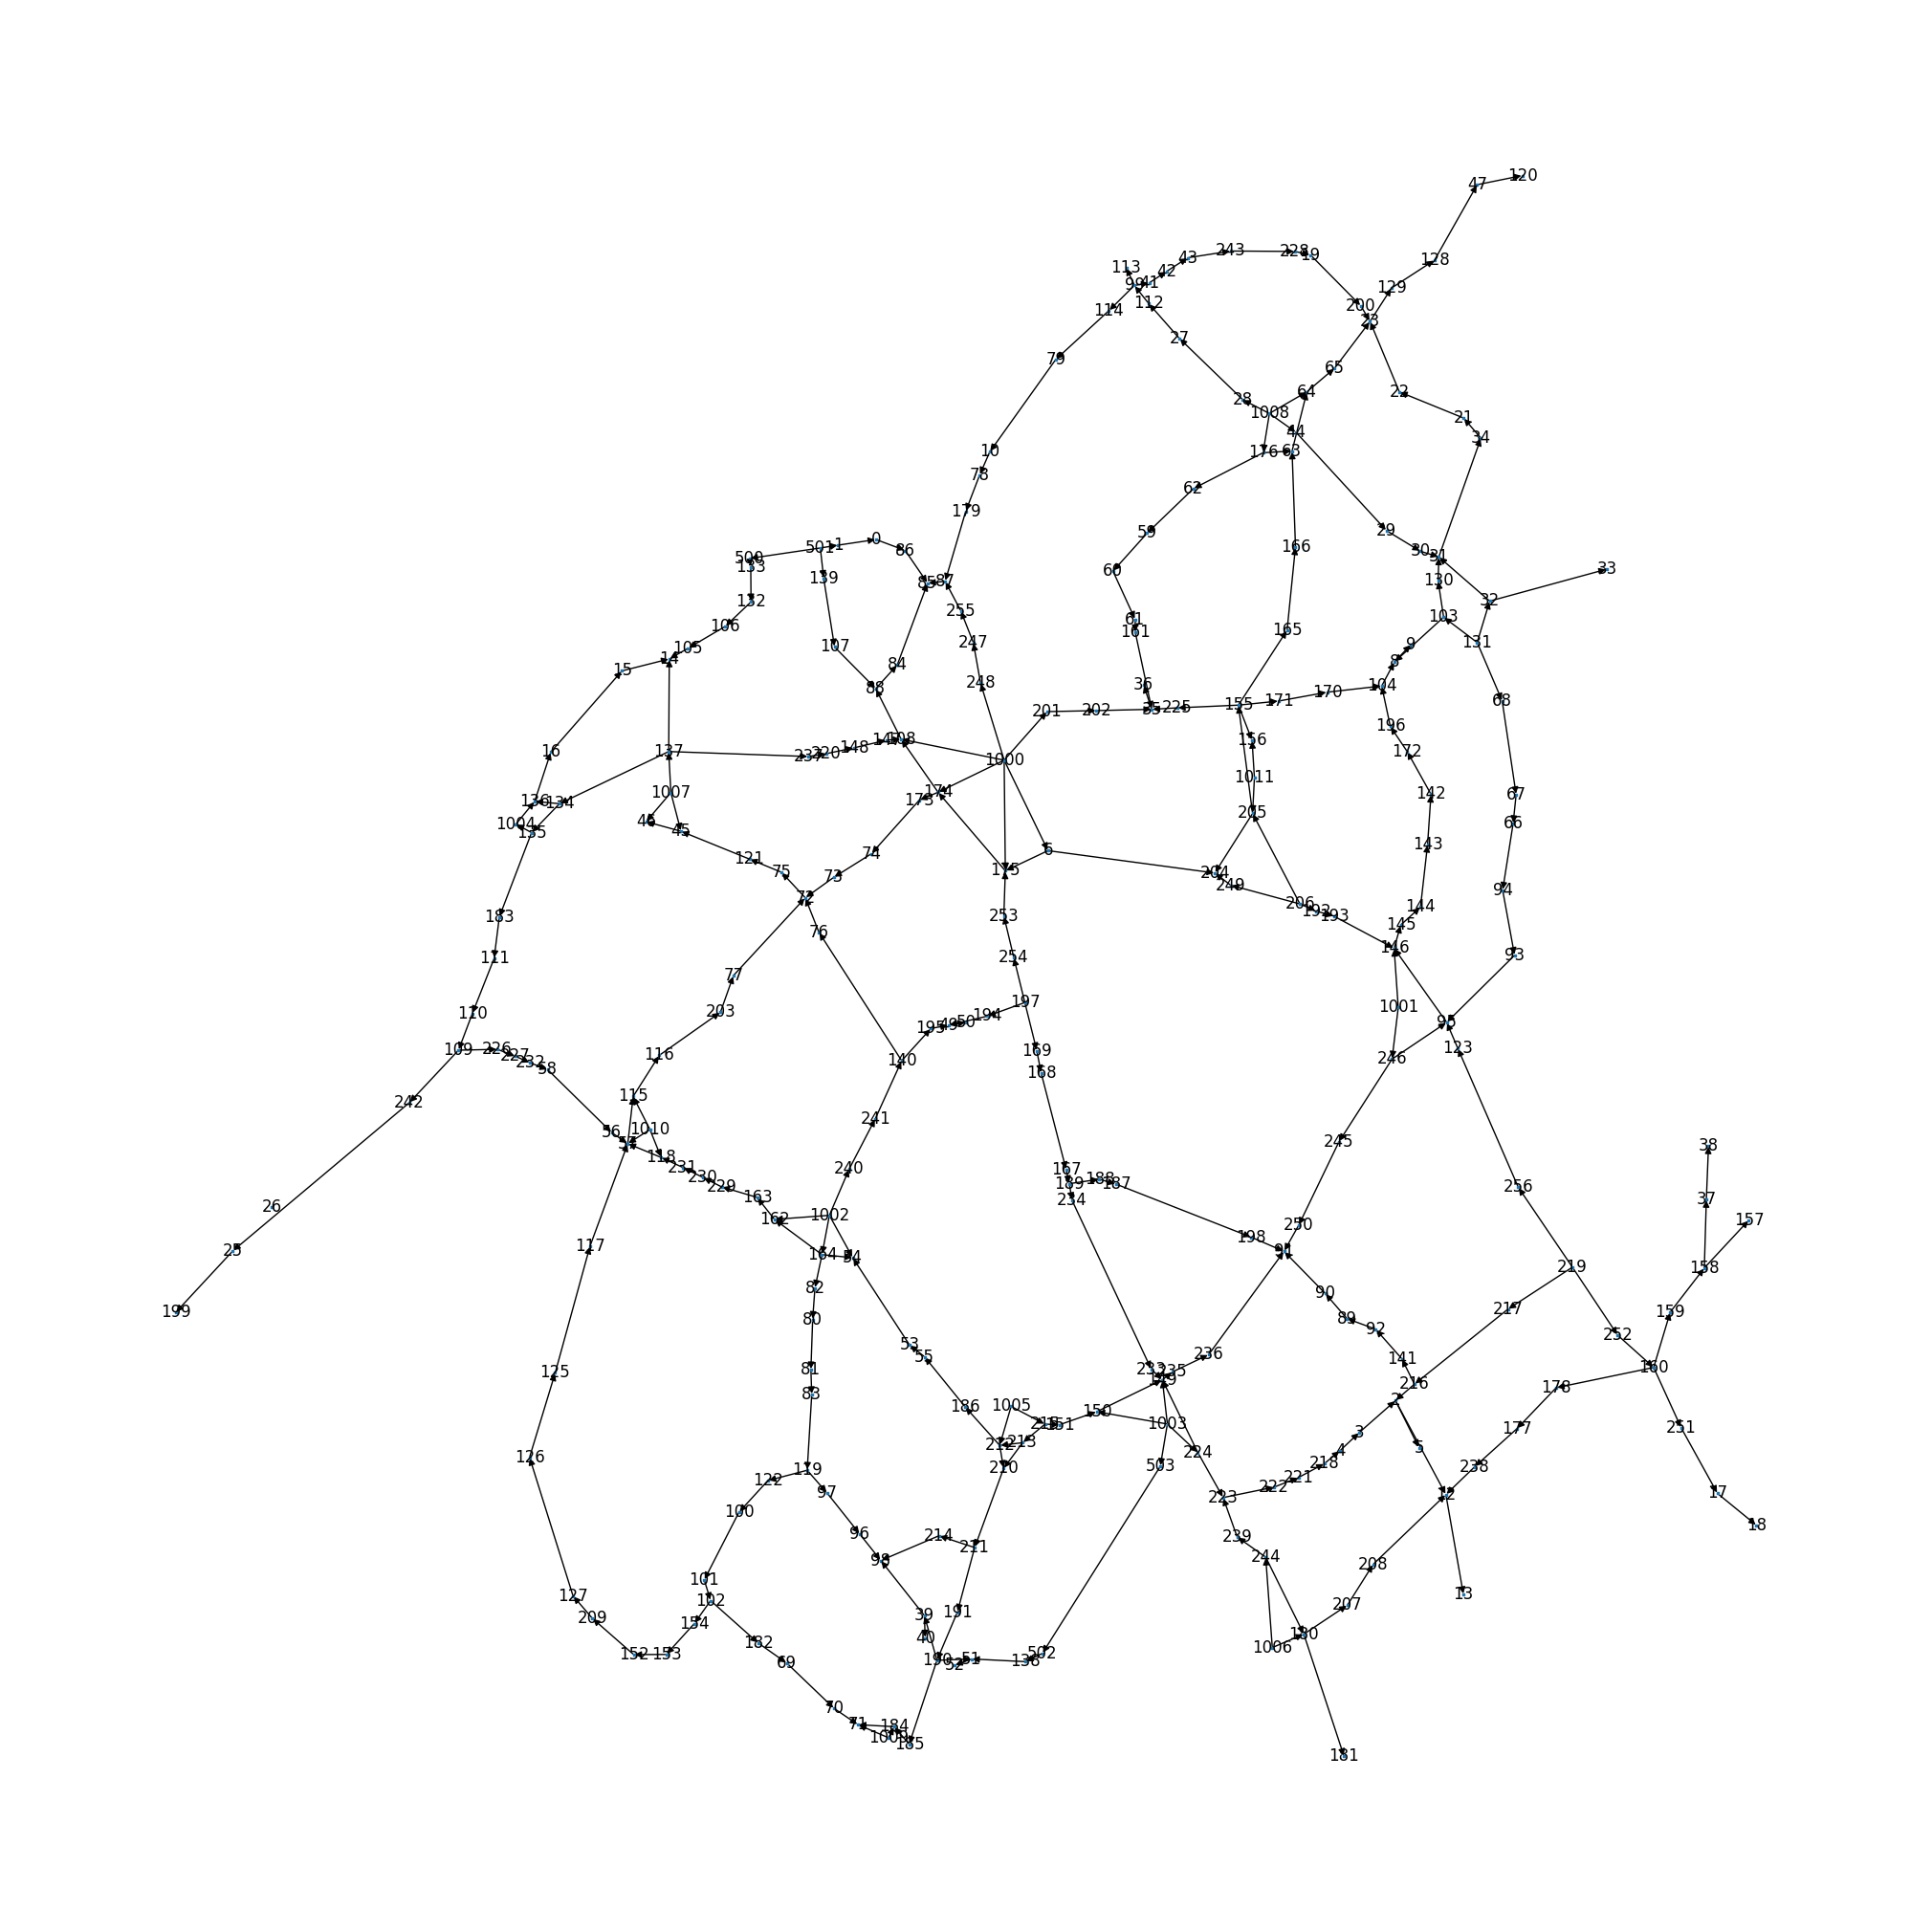

In [9]:
def draw_directed(gfd, lgpd):
    gfd_dir = nx.DiGraph()
    for n in gfd.nodes():
        gfd_dir.add_node(n, x=gfd.nodes[n]['x'], y=gfd.nodes[n]['y'])

    for _, row in lgpd.iterrows():
        gfd_dir.add_edge(int(row['node_start']), int(row['node_end']),
                    wegnr=row['wegnr'],
                    length=row['length'],
                    maxshd=row['maxshd'],
                    nbanen=row['nbanen'])

    plt.figure(figsize=(20, 20))
    pos = {n: [gfd.nodes[n]['x'], gfd.nodes[n]['y']] for n in list(gfd_dir.nodes)}
    nx.draw(gfd_dir, pos=pos, with_labels=True, node_shape='s', node_size=1)

    # subgr = nx.DiGraph(gfd.subgraph(path))
    # nx.draw_networkx_edges(subgr, pos={n: [gfd.nodes[n]['x'], gfd.nodes[n]['y']] for n in list(gfd.nodes)},
    #                     edge_color=colors[i], width=15, style=style[i])
    # i += 1

    plt.show()

draw_directed(gfd, lines_gpd)
gfd = to_directed(gfd, lgpd)
not_removed_nodes = [n for n in gfd.nodes if n not in removed_nodes]
for r in removed_nodes:
    row = nodes_gpd[nodes_gpd['nodeID'] == r]
    nodes_gpd = nodes_gpd.drop([row.index[0]])

gfd = nx.Graph(gfd.subgraph(not_removed_nodes))
lines_gpd = lgpd
# draw_directed(gfd, lgpd)
gfd = to_directed(gfd, lgpd)
nodes_gpd = nodes_gpd.reset_index()

In [10]:
nodes_gpd.to_file('./wegengraaf2slwk/points.shp')
lines_gpd.to_file('./wegengraaf2slwk/lines.shp')